In [1]:
from cc.env import make_env
from cc.examples.neural_ode_model_compact_example import make_neural_ode_model
from cc.train import (
    ModelControllerTrainer, 
    Tracker, make_dataloader, 
    UnsupervisedDataset
)
import jax.random as jrand
import optax
import jax.numpy as jnp
import equinox as eqx

In [2]:
time_limit = 10.0
control_timestep = 0.01

env = make_env("two_segments_v1", time_limit=time_limit, control_timestep=control_timestep, random=1)

In [3]:
# make sure this definition matches exactly (!) the
# definition as it was used in notebook 3
model = make_neural_ode_model(
    env.action_spec(),
    env.observation_spec(),
    env.control_timestep(),
    state_dim=50,
    f_depth=0, 
    u_transform=jnp.arctan
)

In [4]:
# trained in notebook 3
fitted_model = eqx.tree_deserialise_leaves("model.eqx", model)

# Training a controller

In [5]:
from cc.train import TrainingOptionsController
from cc.examples.neural_ode_controller_compact_example import make_neural_ode_controller
from cc.env.collect import random_steps_source
from cc.env.wrappers import AddRefSignalRewardFnWrapper

source = random_steps_source(env, seeds=list(range(30)))
env_w_source = AddRefSignalRewardFnWrapper(env, source)

/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/home/simon/miniforge3/envs/chain_control/lib/python3.9/site-packages/flax/struct.py:136: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [6]:
controller = make_neural_ode_controller(
    env_w_source.observation_spec(),
    env.action_spec(),
    env.control_timestep(),
    5,
    f_depth=0
)

In [7]:
controller_dataloader = make_dataloader(
    UnsupervisedDataset(source.get_references_for_optimisation()),
    jrand.PRNGKey(1,),
    n_minibatches=5
)

optimizer = optax.chain(optax.clip_by_global_norm(1.0), optax.adam(1e-3))

controller_train_options = TrainingOptionsController(
    controller_dataloader, optimizer, 
)

controller_trainer = ModelControllerTrainer(
    fitted_model, controller, controller_train_options=controller_train_options, 
    trackers=[Tracker("loss")]
)

This model has been registered with model name `model0`.
                    When using multiple models individual model names have to
                    be provided by passing a dictionary in the `model` argument


In [8]:
controller_trainer.run(500)

  0%|          | 0/500 [00:00<?, ?it/s]

In [9]:
fitted_controller = controller_trainer.trackers[0].best_model_or_controller()
controller_trainer.trackers[0].best_metric()

0.51609105

In [10]:
from cc.env.collect import collect_exhaust_source

eval_source = random_steps_source(env, seeds=list(range(6)))
# returns a tuple
controller_performance_sample, loop_results = collect_exhaust_source(
    AddRefSignalRewardFnWrapper(env, eval_source), fitted_controller)

Reference Iterator:   0%|          | 0/6 [00:00<?, ?it/s]

In [11]:
# some metadata
# you can use the concept of `loop_observers` to record
# every physical quantity you could think of 
# e.g. angle trajectories or linear accelerations
loop_results

{'episode_length': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]]),
 'episode_return': array([[ -626.46045 ],
        [-1546.8748  ],
        [  -81.49893 ],
        [  -25.560589],
        [-1390.9504  ],
        [  -13.278777]], dtype=float32),
 'episodes': array([[1],
        [1],
        [1],
        [1],
        [1],
        [1]]),
 'steps': array([[1000],
        [1000],
        [1000],
        [1000],
        [1000],
        [1000]]),
 'steps_per_second': array([[613.12202378],
        [661.67778217],
        [664.93422162],
        [640.4663552 ],
        [665.17739474],
        [671.24222022]])}

In [12]:
jnp.mean(-controller_performance_sample.rew)

Array(0.61410457, dtype=float32)

In [13]:
%matplotlib inline

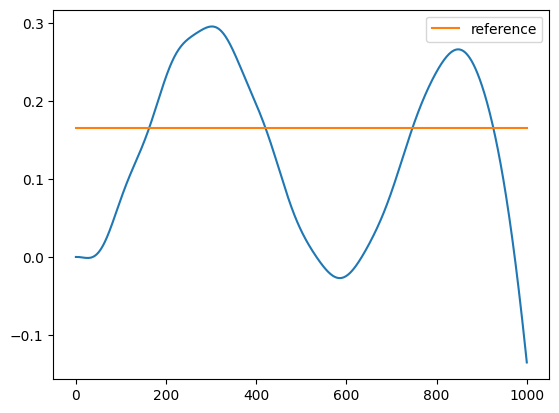

In [14]:
import matplotlib.pyplot as plt 

i = 5
plt.plot(controller_performance_sample.obs["obs"]["xpos_of_segment_end"][i])
plt.plot(controller_performance_sample.obs["ref"]["xpos_of_segment_end"][i], label="reference")
plt.legend()
